### RNN-LSTM 기반의 영어 감정 분석기
##### FRIENDS 시트콤 데이터

In [2]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1. 데이터 로드

In [3]:
## 데이터셋 로드

# Training Set
train_data2 = pd.read_csv('./friends_train_아스키제거_감정코드.csv')

# Dev Set
dev_data2 = pd.read_csv('./friends_dev_아스키제거_감정코드.csv')

# Test Set
test_data2 = pd.read_csv('./friends_test_아스키제거_감정코드.csv')

print("Training_Set : ", len(train_data2))
print("Dev_Set : ", len(dev_data2))
print("Test_Set : ", len(test_data2))

Training_Set :  10561
Dev_Set :  1178
Test_Set :  2764


### 2. 데이터 정제 및 전처리(Train, Dev, Test)
##### 1) 중복 제거
##### 2) Null값 제거
##### 3) 영어, 공백, ' 제외 문자 제거
##### 4) 전처리 후 Null 값 제거
##### 데이터 1차 저장(train_data_set.csv, dev_data_set.csv, test_data_set.csv)

In [4]:
## Train Data 처리

# 1. 중복 확인/제거
train_data2['utterance'].nunique(), train_data2['emotion'].nunique()
train_data2.drop_duplicates(subset=['utterance'], inplace=True)

# 2. Null 값이 존재하는 행 제거
train_data2 = train_data2.dropna(how = 'any')

# 3. 전처리(영어, 공백, ' 을 제외한 문자 제거)
train_data2['utterance'] = train_data2['utterance'].str.replace("[^A-Za-z ']","")
train_data2['utterance'] = train_data2['utterance'].str.strip()
train_data2['utterance'].replace('', np.nan, inplace=True)

# 4. 전처리 후 Null값 처리
train_data2 = train_data2.dropna(how = 'any')

In [5]:
## Dev Data 처리

# 1. 중복 확인/제거
dev_data2['utterance'].nunique(), dev_data2['emotion'].nunique()
dev_data2.drop_duplicates(subset=['utterance'], inplace=True)

# 2. Null 값이 존재하는 행 제거
dev_data2 = dev_data2.dropna(how = 'any')

# 3. 전처리(영어, 공백, ' 을 제외한 문자 제거)
dev_data2['utterance'] = dev_data2['utterance'].str.replace("[^A-Za-z ']","")
dev_data2['utterance'] = dev_data2['utterance'].str.strip()
dev_data2['utterance'].replace('', np.nan, inplace=True)

# 4. 전처리 후 Null값 처리
dev_data2 = dev_data2.dropna(how = 'any')

In [6]:
## Test Data 처리

# 1. 중복 확인/제거
test_data2['utterance'].nunique(), test_data2['emotion'].nunique()
test_data2.drop_duplicates(subset=['utterance'], inplace=True)

# 2. Null 값이 존재하는 행 제거
test_data2 = test_data2.dropna(how = 'any')

# 3. 전처리(영어, 공백, ' 을 제외한 문자 제거)
test_data2['utterance'] = test_data2['utterance'].str.replace("[^A-Za-z ']","")
test_data2['utterance'] = test_data2['utterance'].str.strip()
test_data2['utterance'].replace('', np.nan, inplace=True)

# 4. 전처리 후 Null값 처리
test_data2 = test_data2.dropna(how = 'any')

In [7]:
print('총 샘플의 수(Training_Set) :',len(train_data2))
print('총 샘플의 수(Dev_Set) :',len(dev_data2))
print('총 샘플의 수(Test_Set) :',len(test_data2))

총 샘플의 수(Training_Set) : 9268
총 샘플의 수(Dev_Set) : 1088
총 샘플의 수(Test_Set) : 2500


In [8]:
### 전처리 결과 저장
#중복, null값, 전처리(영어, 공백 제외), 전처리 후 null값 처리까지 한 데이터 저장

# Train Data
train_data2.to_csv("train_data_set.csv", mode='w', index=False)

# Dev Data
dev_data2.to_csv("dev_data_set.csv", mode='w', index=False)

# Test Data
test_data2.to_csv("test_data_set.csv", mode='w', index=False)

### 3. 토큰화

In [9]:
### 전처리 결과를 저장한 데이터 불러오기

train_data2 = pd.read_csv('./train_data_set.csv')
dev_data2 = pd.read_csv('./dev_data_set.csv')
test_data2 = pd.read_csv('./test_data_set.csv')

In [12]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import re # 축약문 치환
from soynlp.normalizer import * # 반복문자 교정
from tensorflow.keras.preprocessing.text import text_to_word_sequence # 토큰화
tokenizer = Tokenizer()

from nltk.corpus import stopwords # StopWord(불용어)
stopwords.words('english')

new_stopwords = stopwords.words('english')
new_stopwords.append("he's")
new_stopwords.append("phoebe")
new_stopwords.append("monica")
new_stopwords.append("ross")
new_stopwords.append("chandler")
new_stopwords.append("joey")
new_stopwords.append("rachel")
new_stopwords.append("dr")
new_stopwords.append("ms")
new_stopwords.append("mr")
new_stopwords.append("mrs")

## Lemma
# Lemmatization
from nltk.stem import WordNetLemmatizer
n = WordNetLemmatizer()

## Stem
# Stemming_Porter
from nltk.stem import PorterStemmer
p = PorterStemmer()

# Stemming_Lancaster
from nltk.stem import LancasterStemmer
l=LancasterStemmer()

# Stemming_SnowballStemmer
from nltk.stem import SnowballStemmer
s = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\server\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\server\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# rule-based 축약문 치환
def char_change(sentence):
    sentence = sentence.lower()
    
    sentence = re.sub(r"ain't", "have not", sentence)
    sentence = re.sub(r"can't", "can not", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"'re", " are", sentence)
    sentence = re.sub(r"y'", "you ", sentence)
    sentence = re.sub(r"'ll", " will", sentence)
    sentence = re.sub(r"'ve", " have", sentence)
    sentence = re.sub(r"'d", " would", sentence)
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"there's", "there is", sentence)
    sentence = re.sub(r"what's", "what is", sentence)
    sentence = re.sub(r"who's", "who is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"let's", "let us", sentence)
    sentence = re.sub(r"c'mon", "come on", sentence)
    sentence = re.sub(r"c'mere", "come here", sentence)
    
    return sentence

In [14]:
## Train 데이터

X_train2 = []

for sentence in train_data2['utterance']:
    temp_X2 = []
    
    # 축약문 교정
    temp_X2 = char_change(sentence)
    
    # 반복문자 교정
    temp_X2 = repeat_normalize(temp_X2, num_repeats=1)
    
    # 토큰화
    temp_X2 = text_to_word_sequence(temp_X2)
    
    # Stopwords(불용어) 제거
    #temp_X2 = [word for word in temp_X2 if not word in stopwords.words('english')]
    temp_X2 = [word for word in temp_X2 if not word in new_stopwords]
    
    # Lemmatization
    temp_X2 = [n.lemmatize(word, 'v') for word in temp_X2]
    
    # Stemming_Porter
    #temp_X2 = [p.stem(word) for word in temp_X2]
    
    # Stemming_Lancaster
    #temp_X2 = [l.stem(word) for word in temp_X2]
    
    # Stemming_SnowballStemmer
    #temp_X2 = [s.stem(word) for word in temp_X2]
    
    X_train2.append(temp_X2)

In [15]:
## Dev 데이터

X_dev2 = []

for sentence in dev_data2['utterance']:
    temp_X2 = []
    
    # 축약문 교정
    temp_X2 = char_change(sentence)
    
    # 반복문자 교정
    temp_X2 = repeat_normalize(temp_X2, num_repeats=1)
    
    # 토큰화
    temp_X2 = text_to_word_sequence(temp_X2)
    
    # 불용어 제거
    #temp_X2 = [word for word in temp_X2 if not word in stopwords.words('english')]
    temp_X2 = [word for word in temp_X2 if not word in new_stopwords]
    
    # Lemmatization
    temp_X2 = [n.lemmatize(word, 'v') for word in temp_X2]
    
    # Stemming_Porter
    #temp_X2 = [p.stem(word) for word in temp_X2]
    
    # Stemming_Lancaster
    #temp_X2 = [l.stem(word) for word in temp_X2]
    
    # Stemming_SnowballStemmer
    #temp_X2 = [s.stem(word) for word in temp_X2]
    
    X_dev2.append(temp_X2)

In [16]:
## Test 데이터

X_test2 = []

for sentence in test_data2['utterance']:
    temp_X2 = []
    
    # 축약문 교정
    temp_X2 = char_change(sentence)
    
    # 반복문자 교정
    temp_X2 = repeat_normalize(temp_X2, num_repeats=1)    
    
    # 토큰화
    temp_X2 = text_to_word_sequence(temp_X2)
    
    # 불용어 제거
    #temp_X2 = [word for word in temp_X2 if not word in stopwords.words('english')]
    temp_X2 = [word for word in temp_X2 if not word in new_stopwords]
    
    # Lemmatization
    temp_X2 = [n.lemmatize(word, 'v') for word in temp_X2]
    
    # Stemming_Porter
    #temp_X2 = [p.stem(word) for word in temp_X2]
    
    # Stemming_Lancaster
    #temp_X = [l.stem(word) for word in temp_X2]
    
    # Stemming_SnowballStemmer
    #emp_X2 = [s.stem(word) for word in temp_X2]
    
    X_test2.append(temp_X2)

In [17]:
print(X_dev2[:50])

[['know'], ['mean', 'end', 'era'], ['gonna', 'miss'], ['oh', 'god', 'gonna', 'miss', 'much'], [], ['mean', 'gonna', 'live', 'together', 'anymore'], ['yeah', 'sweetie'], ['really'], [], ['something', 'impulsively', 'decide', 'inin', 'vegas', 'something', 'really', 'want'], ['let', 'finish', 'okay'], ['nono', 'wait'], [], ['go', 'happen', 'gonna', 'move'], ['right', 'hang'], [], ['well', 'pretty', 'much', 'gist', 'well', 'except', 'poem', 'read', 'poem', 'right'], ['goodbye', 'ursula', 'miss', 'ps', 'mom', 'live', 'montauk', 'write'], ['umm', 'shut'], ['saw', 'check', 'game', 'last', 'night'], ['huh'], ['still', 'think', 'boyfriend', 'material'], ['white', 'plain', 'oh', 'sound', 'like', 'magical', 'place'], ['yes', 'know', 'white', 'plain'], ['like', 'know'], ['tell', 'anything'], ['bet', 'great', 'story', 'behind'], ['wow'], ['god', 'oh', 'perfect'], ['yes', 'yes'], ['uh', 'yore', 'like', 'days', 'yore', 'know'], ['well', 'period'], ['yeah'], ['ohh', 'okay', 'give', 'old', 'time', 'pri

### 4. 정수 인코딩

In [18]:
# 빈도순 단어 집합 생성 -> 높은 정수값은 빈도가 낮은 것
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train2)

#print(tokenizer.word_index)

In [19]:
total_cnt = len(tokenizer.word_index)
print(total_cnt)

4993


In [20]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('[총 단어 수] 단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

[총 단어 수] 단어 집합(vocabulary)의 크기 : 4993
등장 빈도가 1번 이하인 희귀 단어의 수: 2707
단어 집합에서 희귀 단어의 비율: 54.21590226316844
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.188379627170853


In [21]:
# 전체 단어 개수 중 빈도수 2번 이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2

vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2288


In [22]:
# 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠습니다. 다시 말해 정수 1번으로 할당
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train2)

X_train2 = tokenizer.texts_to_sequences(X_train2)
X_dev2 = tokenizer.texts_to_sequences(X_dev2)
X_test2 = tokenizer.texts_to_sequences(X_test2)

In [23]:
y_train2 = np.array(train_data2['emotion_code'])
y_dev2 = np.array(dev_data2['emotion_code'])
y_test2 = np.array(test_data2['emotion_code'])

In [24]:
X_train2 = np.array(X_train2)
X_dev2 = np.array(X_dev2)
X_test2 = np.array(X_test2)

### 5. 빈 샘플 제거

In [25]:
drop_train2 = [index for index, sentence in enumerate(X_train2) if len(sentence) < 1]

In [26]:
#print(drop_train2)
# 빈 샘플들을 제거
X_train2 = np.delete(X_train2, drop_train2, axis=0)
y_train2 = np.delete(y_train2, drop_train2, axis=0)

### 6. 패딩

대사 최대 길이 : 32
대사 평균 길이 : 4.203370911932136


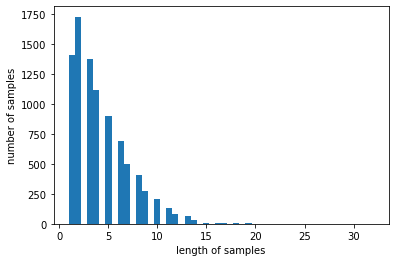

In [27]:
print('대사 최대 길이 :',max(len(l) for l in X_train2))
print('대사 평균 길이 :',sum(map(len, X_train2))/len(X_train2))
plt.hist([len(s) for s in X_train2], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [29]:
max_len = 10
below_threshold_len(max_len, X_train2)

전체 샘플 중 길이가 10 이하인 샘플의 비율: 96.26074338653868


In [30]:
# 모든 샘플 길이 통일
X_train2 = pad_sequences(X_train2, maxlen=max_len)
X_dev2 = pad_sequences(X_dev2, maxlen=max_len)
X_test2 = pad_sequences(X_test2, maxlen=max_len)

In [31]:
# 훈련/검증/테스트용 레이블의 원-핫 인코딩
from keras.utils import to_categorical

y_train2 = to_categorical(y_train2)
y_dev2 = to_categorical(y_dev2)
y_test2 = to_categorical(y_test2)

### 7. LSTM 모델 설정 및 학습/평가

In [32]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

model2 = Sequential()

model2.add(Embedding(vocab_size, 128))
model2.add(LSTM(128))
model2.add(Dense(8, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('friends_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [33]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history2 = model2.fit(X_train2, y_train2, batch_size=64, epochs=10, callbacks=[es, mc], validation_data=(X_dev2, y_dev2))

Epoch 1/10
134/140 [===========================>..] - ETA: 0s - loss: 1.6433 - acc: 0.4374
Epoch 00001: val_acc improved from -inf to 0.41085, saving model to friends_best_model.h5
140/140 [==============================] - 1s 9ms/step - loss: 1.6378 - acc: 0.4400 - val_loss: 1.7036 - val_acc: 0.4108
Epoch 2/10
139/140 [============================>.] - ETA: 0s - loss: 1.4858 - acc: 0.4753
Epoch 00002: val_acc improved from 0.41085 to 0.43658, saving model to friends_best_model.h5
140/140 [==============================] - 1s 6ms/step - loss: 1.4852 - acc: 0.4754 - val_loss: 1.6265 - val_acc: 0.4366
Epoch 3/10
136/140 [============================>.] - ETA: 0s - loss: 1.3155 - acc: 0.5327
Epoch 00003: val_acc did not improve from 0.43658
140/140 [==============================] - 1s 6ms/step - loss: 1.3140 - acc: 0.5338 - val_loss: 1.6411 - val_acc: 0.4357
Epoch 4/10
136/140 [============================>.] - ETA: 0s - loss: 1.1862 - acc: 0.5809- ETA: 0s - loss: 1.1354 
Epoch 00004: va

In [34]:
loaded_model2 = load_model('friends_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model2.evaluate(X_test2, y_test2)[1]))

79/79 [==============================] - 0s 1ms/step - loss: 1.5844 - acc: 0.4808

 테스트 정확도: 0.4808


In [37]:
def sentiment_predict(new_sentence):
    
    #전처리(영어, 공백, ' 을 제외한 문자 제거)
    new_sentence = re.sub(r"[^A-Za-z ']", "", new_sentence)
    
    # 축약문 처리
    temp_X2 = char_change(new_sentence)
    
    # 반복문자 교정
    temp_X2 = repeat_normalize(temp_X2, num_repeats=1)
    
    #토큰화
    new_sentence = text_to_word_sequence(new_sentence)  
    
    #Stopword(불용어) 제거
    #new_sentence = [word for word in new_sentence if not word in stopwords.words('english')]
    new_sentence = [word for word in new_sentence if not word in new_stopwords]
    
    #Lemmatization
    new_sentence = [n.lemmatize(word, 'v') for word in new_sentence] 
    
    # Stemming_Porter
    #new_sentence = [p.stem(word) for word in new_sentence]
    
    # Stemming_Lancaster
    #new_sentence = [l.stem(word) for word in new_sentence]
    
    # Stemming_SnowballStemmer
    #new_sentence = [s.stem(word) for word in new_sentence]    
    
    #정수 인코딩
    encoded = tokenizer.texts_to_sequences([new_sentence])
    
    #패딩
    pad_new = pad_sequences(encoded, maxlen = max_len)
    
    score = loaded_model2.predict(pad_new)

    #val = np.max(score)
    val_index = np.argmax(score)

    if(val_index==0):
        return "anger"
    elif(val_index==1):
        return "disgust"
    elif(val_index==2):
        return "fear"
    elif(val_index==3):
        return "joy"
    elif(val_index==4):
        return "neutral"
    elif(val_index==5):
        return "non-neutral"
    elif(val_index==6):
        return "sadness"
    elif(val_index==7):
        return "surprise"

In [38]:
eval_data = pd.read_csv('./[전처리]en_data.csv', engine='python', encoding='utf-8')
eval_data['Predicted'] = 0

for i in range(len(eval_data)):
    Predicted = sentiment_predict(eval_data['utterance'][i])
    eval_data['Predicted'][i] = Predicted
    
eval_data.drop(['i_dialog'], axis='columns', inplace=True)
eval_data.drop(['i_utterance'], axis='columns', inplace=True)
eval_data.drop(['speaker'], axis='columns', inplace=True)
eval_data.drop(['utterance'], axis='columns', inplace=True)

eval_data.to_csv("result_2019512014_이동환.csv", index=False)

<ipython-input-38-cfee1748ee8f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_data['Predicted'][i] = Predicted
C:\Users\server\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
